In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm # p-values
from sklearn.model_selection import train_test_split
import xgboost as xgb
import catboost as cat
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import itertools
from tqdm import tqdm, tnrange
pd.options.display.max_columns = 1000

from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
test = pd.read_csv('test_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
RUL = pd.read_csv('RUL_FD001.txt', parse_dates=False, decimal=".", header=None)
tableNA = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1)
tableNA.columns = ['train', 'test']
#We will first drop the columns that consisted of missing values:
train.drop(train.columns[[-1,-2]], axis=1, inplace=True)
test.drop(test.columns[[-1,-2]], axis=1, inplace=True)

cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
train.columns = cols
test.columns = cols

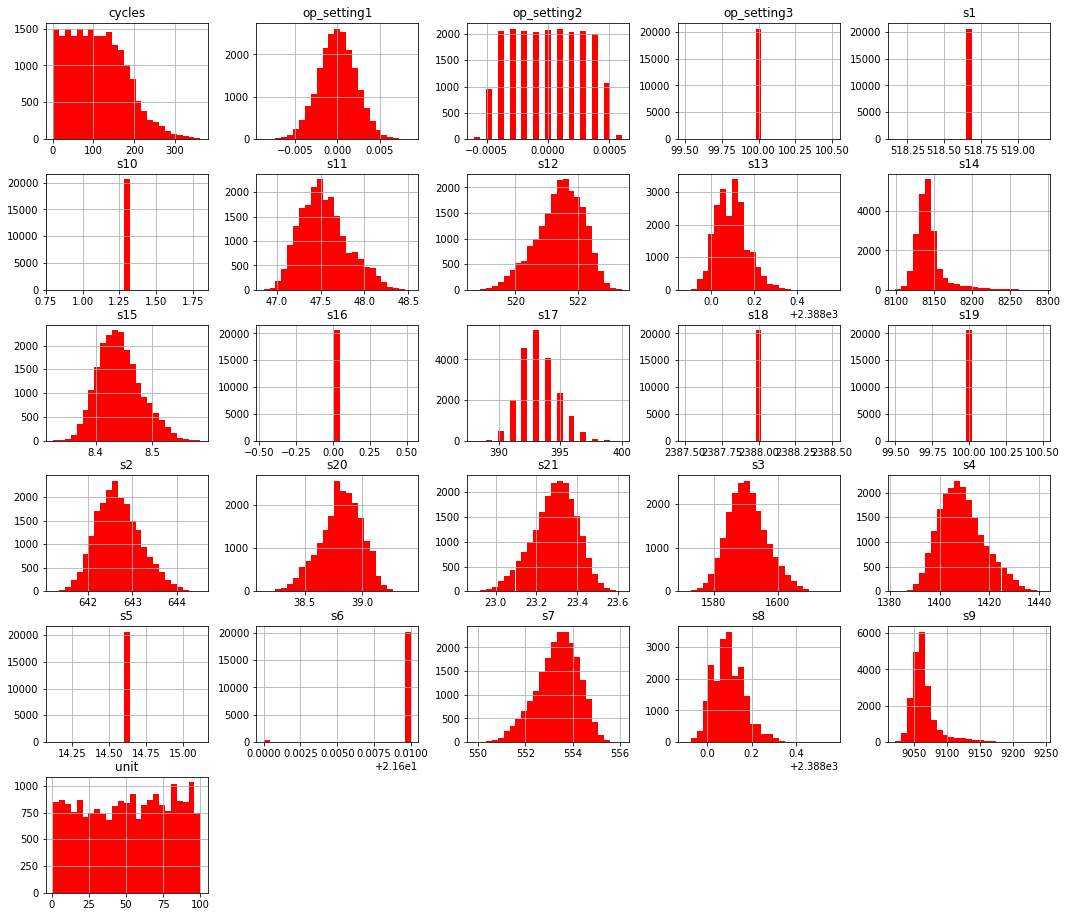

In [3]:
train.hist(bins=25, figsize=(18,16),color='red')
plt.show()

In [4]:
train.drop(['s1', 's5','s6', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)
test.drop(['s1', 's5','s6', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)

In [5]:
cyclestrain = train.groupby('unit', as_index=False)['cycles'].max()
cyclestest = test.groupby('unit', as_index=False)['cycles'].max()

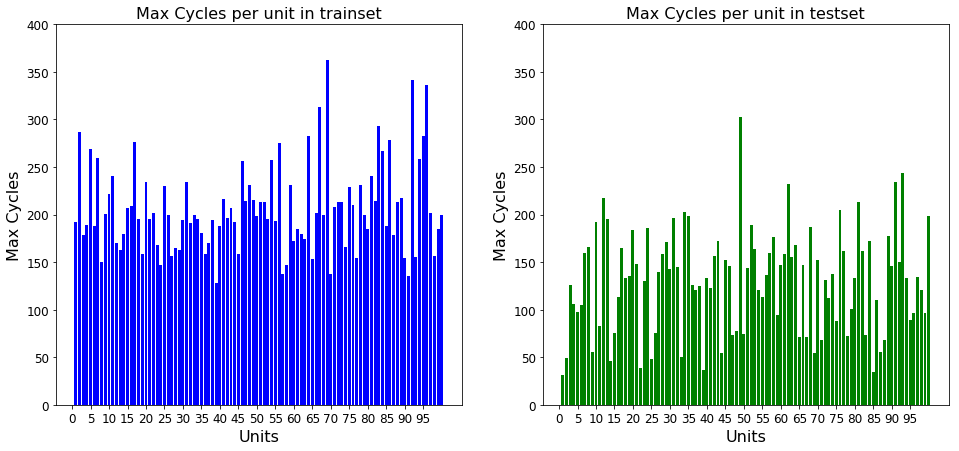

In [6]:
fig = plt.figure(figsize = (16,7))
fig.add_subplot(1,2,1)
bar_labels = list(cyclestrain['unit'])
bars = plt.bar(list(cyclestrain['unit']), cyclestrain['cycles'], color='Blue')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max Cycles', fontsize=16)
plt.title('Max Cycles per unit in trainset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
fig.add_subplot(1,2,2)
bars = plt.bar(list(cyclestest['unit']), cyclestest['cycles'], color='green')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max Cycles', fontsize=16)
plt.title('Max Cycles per unit in testset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [7]:
train = pd.merge(train, train.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
train.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
train['TTF'] = train['maxcycles'] - train['cycles']

In [8]:
#scaler = MinMaxScaler()
ntrain = train.copy()
#ntrain.iloc[:,2:18] = scaler.fit_transform(ntrain.iloc[:,2:18])
ntest = test.copy()
#pd.DataFrame(ntest.columns).transpose()
#ntest.iloc[:,2:18] = scaler.transform(ntest.iloc[:,2:18])
ntest.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,13096.0,51.543907,28.289423,1.0000,28.0000,52.0000,76.0000,100.0000
cycles,13096.0,76.836515,53.057749,1.0000,33.0000,69.0000,113.0000,303.0000
op_setting1,13096.0,-0.000011,0.002203,-0.0082,-0.0015,0.0000,0.0015,0.0078
op_setting2,13096.0,0.000004,0.000294,-0.0006,-0.0002,0.0000,0.0003,0.0007
s2,13096.0,642.475088,0.400899,641.1300,642.1975,642.4600,642.7400,644.3000
s3,13096.0,1588.099204,5.003274,1569.0400,1584.6000,1587.9900,1591.3625,1607.5500
s4,13096.0,1404.735362,6.688309,1384.3900,1399.9500,1404.4400,1409.0500,1433.3600
s7,13096.0,553.757523,0.681286,550.8800,553.3100,553.8000,554.2400,555.8400
s8,13096.0,2388.070964,0.057442,2387.8900,2388.0300,2388.0700,2388.1100,2388.3000
s9,13096.0,9058.407363,11.436261,9024.5300,9051.0200,9057.3200,9064.1100,9155.0300


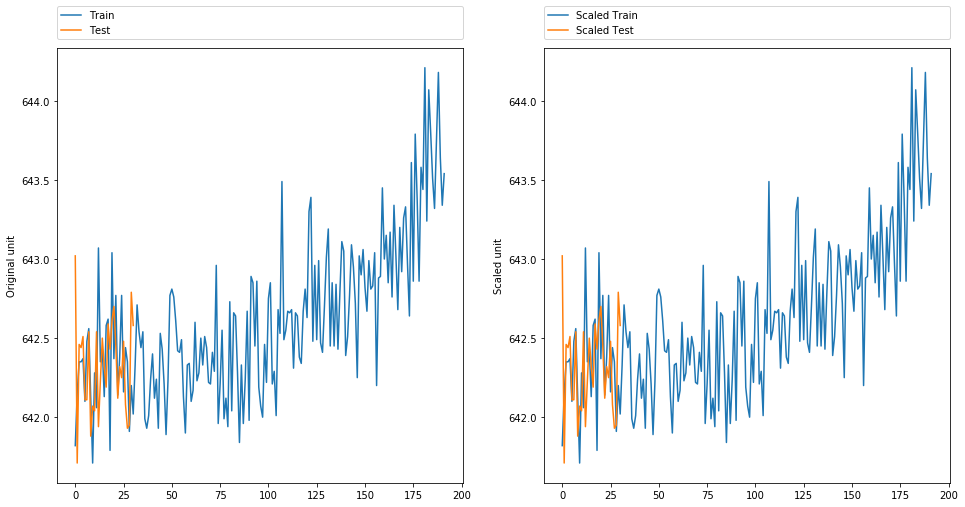

In [9]:
fig = plt.figure(figsize = (16, 8))
fig.add_subplot(1,2,1)
plt.plot(train[train.unit==1].s2)
plt.plot(test[test.unit==1].s2)
plt.legend(['Train','Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(ntrain[ntrain.unit==1].s2)
plt.plot(ntest[ntest.unit==1].s2)
plt.legend(['Scaled Train','Scaled Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

In [10]:
def fractionTTF(dat,q):
    return(dat.TTF[q]-dat.TTF.min()) / float(dat.TTF.max()-dat.TTF.min())
fTTFz = []
fTTF = []

for i in range(train['unit'].min(),train['unit'].max()+1):
    dat=train[train.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)
ntrain['fTTF'] = fTTF

In [11]:
ntrain.head()

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,maxcycles,TTF,fTTF
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192,191,1.000000
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,192,190,0.994764
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,192,189,0.989529
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,192,188,0.984293
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,192,187,0.979058


In [12]:
X_train = ntrain.iloc[:,1:18]
Y_train = ntrain.iloc[:, 20]
X_test = ntest.iloc[:,1:18]

In [13]:
Y_train.head()

0    1.000000
1    0.994764
2    0.989529
3    0.984293
4    0.979058
Name: fTTF, dtype: float64

In [14]:
X_train.head()

,cycles,op_setting1,op_setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


X_train['mean_samp'] = X_train.mean(axis=1)
X_train['var_samp'] = np.log1p(X_train.var(axis=1))
X_train['sum_samp'] = X_train.sum(axis=1)

X_test['mean_samp'] = X_test.mean(axis=1)
X_test['var_samp'] = np.log1p(X_test.var(axis=1))
X_test['sum_samp'] = X_test.sum(axis=1)

# Feature Selection
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax<0.805):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols

selected_features_BE

In [15]:
X_train1 = X_train
X_train1.head()

,cycles,op_setting1,op_setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [16]:
X_test1 = X_test
X_test1.head()

,cycles,op_setting1,op_setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130


In [17]:
kfold = 5
fold = list(KFold(n_splits = kfold, shuffle = True, random_state = 2019).split(X_train1))

In [18]:
sub1 = pd.DataFrame()
sub1["target"] = np.zeros_like(X_test1.cycles.values)
subb1 = pd.DataFrame()
subb1["train"] = np.zeros_like(X_train1.cycles.values)
score = 0
for i, (train_index, test_index) in enumerate(fold):
    print("Fold - %.f" %(i+1))
    X_tr = X_train1.loc[train_index, :]
    y_tr = Y_train[train_index]
    X_valid = X_train1.loc[test_index, :]
    y_valid = Y_train[test_index]
    
    model = cat.CatBoostRegressor(iterations=600,
                                 learning_rate=0.005,
                                 depth=3,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.99,
                                 random_seed = 2019,
                                 bagging_temperature = 0.001,
                                 metric_period = None,
                                 early_stopping_rounds=50 
                                )
    model.fit(X_tr, y_tr, eval_set=(X_valid, y_valid), verbose = False)
    
    test_pred = model.predict(X_test1)
    valid_pred = model.predict(X_valid)
    train_pred = model.predict(X_train1)
    
    score += np.sqrt(mean_squared_error(y_valid, valid_pred))/kfold
    
    sub1["target"] += test_pred/kfold
    subb1["train"] += train_pred/kfold
    
    del X_tr, X_valid, y_tr, y_valid
    gc.collect()
print("Training RMSE: ", np.sqrt(mean_squared_error(Y_train, subb1["train"].values)))
print("Validation RMSE: ", score)

Fold - 1
Fold - 2
Fold - 3
Fold - 4
Fold - 5
Training RMSE:  0.06938971586930641
Validation RMSE:  0.06961408760927681


In [19]:
score = model.predict(X_test1)
print(score.min(), score.max())

0.07971763025666088 0.912680403425267


In [20]:
test1 = pd.merge(test, test.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
test1.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
test1['score'] = score
def totcycles(data):
    return(data['cycles'] / (1-data['score']))
    
test1['maxpredcycles'] = totcycles(test1)
def RULfunction(data):
    return(data['maxpredcycles'] - data['maxcycles'])

test1['RUL'] = RULfunction(test1)

In [21]:
t = test1.columns == 'RUL'
ind = [i for i, x in enumerate(t) if x]

predictedRUL = []

for i in range(test1.unit.min(), test1.unit.max()+1):
    npredictedRUL=test1[test1.unit==i].iloc[test1[test1.unit==i].cycles.max()-1,ind]
    predictedRUL.append(npredictedRUL)

xtrueRUL = list(RUL.loc[:,0])
otrueRUL = []

for i in range(0,len(xtrueRUL)):
    otrueRUL = np.concatenate((otrueRUL, list(reversed(np.arange(xtrueRUL[i])))))
    
xpredictedRUL = list(round(x) for x in predictedRUL)
opredictedRUL = []

for i in range(0,len(xpredictedRUL)):
    opredictedRUL = np.concatenate((opredictedRUL, list(reversed(np.arange(float(xpredictedRUL[i]))))))

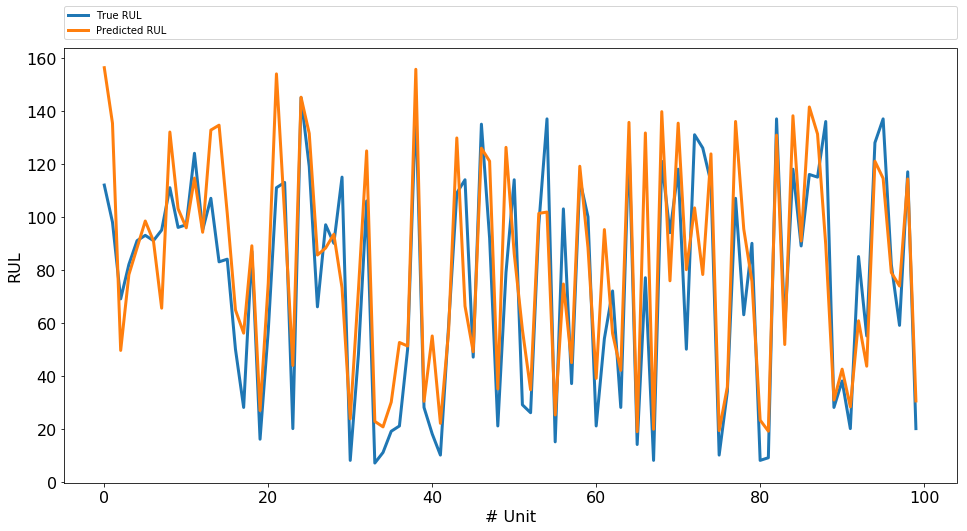

In [22]:
plt.figure(figsize = (16, 8))
plt.plot(RUL,linewidth=3)
plt.plot(predictedRUL,linewidth=3)
plt.xlabel('# Unit', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('RUL', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['True RUL','Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.show()

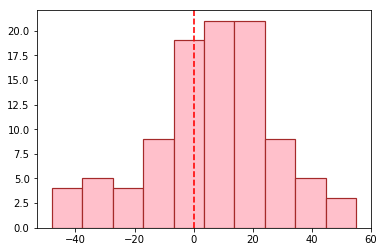

In [23]:
df1 = pd.concat([pd.Series(RUL[0]), pd.Series(xpredictedRUL)], axis=1)
df1.columns = ['true', 'predicted']
df1['diff'] = df1['predicted']-df1['true']

plt.hist(df1['diff'].astype(int), bins=10, color="pink", edgecolor='brown', linewidth=1.2)
plt.axvline(0, color="red", linestyle='dashed', linewidth=1.6)
plt.show()

In [24]:
pd.DataFrame({'Count': [(df1['diff'].astype(int)<0).sum(), (df1['diff'].astype(int)==0).sum(), 
                        (df1['diff'].astype(int)>0).sum()]}, columns=['Count'], index=['Smaller', 'Zero', 'Larger'])

,Count
Smaller,31
Zero,2
Larger,67


In [25]:
mse = mean_squared_error(RUL, xpredictedRUL)
print (mse)
print ('Root Mean Squared Error (RMSE): '+ str(np.sqrt(mse)))

482.07
Root Mean Squared Error (RMSE): 21.956092548538777
